Experiment 2020/05/19
- Using xgb regressor
- with feature selection based on Pearson correlation coefficients between features
- with cross-validation
- with the graph edge weights based on shortest path length in meters
- use R^2 scoring to fit the model
- without grid search, use the bset hyperparameters selected in the previous experiments to train one model
- create prediction graphs for presentation 

In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

import pickle
import networkx as nx
import xgboost as xgb

import random

In [2]:
def load_pickle(filename):
    d = None
    with open(filename, mode='rb') as f:
        d = pickle.load(f)
    return d

def get_weight_dicts(graph_file):
    graph = load_pickle(graph_file)

    detector_to_edge = dict()
    lst_channels = []

    for u, v, edge_data in graph.edges(data=True):
        if 'detector_info' in edge_data:
            detector_info = edge_data['detector_info']
            detector_id = detector_info['id']
            detector_to_edge[detector_id] = (u, v)
            lst_channels.append(detector_id)

    dict_in_weights = dict()
    for detector_id, (u, v) in detector_to_edge.items():
        dict_in_weights[detector_id] = dict()
        dict_weights = dict_in_weights[detector_id]
        for detector_id_n, (u_n, v_n) in detector_to_edge.items():
            # the channel itself and the opposite channel are not taken into account in computing neighbouring influence
            if detector_id == detector_id_n or detector_id[:-5] == detector_id_n[:-5]:
            # if detector_id == detector_id_n:
                dict_weights[detector_id_n] = 0.0
            else:
                try:
                    path = nx.shortest_path(graph, source=v_n, target=u, weight='length')
                    path_length_meters = sum([graph.get_edge_data(path[i], path[i + 1])['length']
                                              for i in range(len(path) - 1)])
                    if path_length_meters == 0:
                        dict_weights[detector_id_n] = 1.0
                    else:
                        dict_weights[detector_id_n] = 1.0 / path_length_meters
                except nx.NetworkXNoPath:
                    dict_weights[detector_id_n] = 0.0

    dict_out_weights = dict()
    for detector_id, (u, v) in detector_to_edge.items():
        dict_out_weights[detector_id] = dict()
        dict_weights = dict_out_weights[detector_id]
        for detector_id_n, (u_n, v_n) in detector_to_edge.items():
            # the channel itself and the opposite channel are not taken into account in computing neighbouring influence
            if detector_id == detector_id_n or detector_id[:-5] == detector_id_n[:-5]:
            # if detector_id == detector_id_n:
                dict_weights[detector_id_n] = 0.0
            else:
                try:
                    path = nx.shortest_path(graph, source=v, target=u_n, weight='length')
                    path_length_meters = sum([graph.get_edge_data(path[i], path[i + 1])['length']
                                              for i in range(len(path) - 1)])
                    if path_length_meters == 0:
                        dict_weights[detector_id_n] = 1.0
                    else:
                        dict_weights[detector_id_n] = 1.0 / path_length_meters
                except nx.NetworkXNoPath:
                    dict_weights[detector_id_n] = 0.0

    return lst_channels, dict_in_weights, dict_out_weights


In [3]:
def series_to_supervised(data, target, n_lags=1, n_leads=0, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a Pandas DataFrame.
        tareget: List of the target column names.
        n_lags: Number of lags for the observations (X). (n>=1; time steps: [-n,-n+1,..., -1] )
        n_leads: Number of time steps ahead for the prediction (y). (n>=0; time step: n; 0 is the index of "now")
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame for supervised learning.
    """

    df_tars = data[[target]]
    df_vars = data

    n_tars = df_tars.shape[1]
    n_vars = data.shape[1]

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lags, 0, -1):
        cols.append(data.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t+n)
    if n_leads == 0:
        cols.append(df_tars)
        names += [('tar%d(t)' % (j + 1)) for j in range(n_tars)]
    else:
        cols.append(df_tars.shift(-n_leads))
        names += [('tar%d(t+%d)' % (j + 1, n_leads)) for j in range(n_tars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


# Define a LSTM sequential model
def create_model(epochs, num_steps, num_feaures):

    learning_rate = 3 * 1e-4
    decay_rate = learning_rate / epochs
    momentum = 0.9  

    # design network
    model = Sequential()
    model.add(LSTM(80, input_shape=(num_steps, num_feaures), return_sequences=True))
    model.add(LSTM(80))
    model.add(Dense(80))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", 
              optimizer=tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate),
              metrics=["mae"])    
    
    return model

In [4]:
def algorithm_pipeline(X_train_data, y_train_data,
                       model, param_grid, cv=10, scoring_fit='r2',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    return fitted_model

In [5]:
def get_features_neighbouring_channels(df, channel, lst_valid_channels, weights):
    """
    Get vehicle count features from the data for neighbouring channels,
    by using the weights on the edges of the graph.
    """

    # get the DateTime series of the data for the channel being processed
    df_temp = df[df['Channel'] == channel]
    df_neighbours = df_temp[['DateTime']]

    dict_weights_for_ch = weights[channel]
    i = 0
    column_list = []
    for other_ch in dict_weights_for_ch:
        # Get the vehicle count features for a different channel
        df_other_ch = df[df['Channel'] == other_ch]
        if df_other_ch.shape[0] == 0 or other_ch == channel:
            continue
        df_other_ch = df_other_ch[['DateTime', 'Totaal Abs.']]
        df_other_ch['Weighted_Total'] = df_other_ch['Totaal Abs.'] * dict_weights_for_ch[other_ch]
        df_other_ch = df_other_ch.drop(['Totaal Abs.'], axis=1)
        df_other_ch.columns = ['DateTime', 'W_Total_n_' + str(i)]
        column_list.append('W_Total_n_' + str(i))
        # Join the vehicle count features for other detectors at each time stamp
        df_neighbours = pd.merge(df_neighbours, df_other_ch, on=['DateTime'], how='left')
        i += 1

    # df_neighbours.set_index('DateTime')

    df_neighbours['sum'] = df_neighbours[column_list].sum(axis=1)
    df_neighbours['max'] = df_neighbours[column_list].max(axis=1)
    # df_neighbours['min'] = df_neighbours[column_list].min(axis=1)
    df_neighbours['avg'] = df_neighbours[column_list].mean(axis=1)
    df_neighbours['std'] = df_neighbours[column_list].std(axis=1)

    df_neighbours_features = df_neighbours.drop(column_list, axis=1)

    return df_neighbours_features

In [6]:
def get_enriched_data_for_one_month(df, df_channels, lst_valid_channels, weights_in, weights_out):
    
    df_with_channel = pd.merge(df, df_channels, on=['Detector_Code', 'Start', 'End'], how='left')
    df_with_channel = df_with_channel[df_with_channel['Channel'].notnull()]

    lst_enriched_df = []

    for channel in lst_valid_channels:
        # Get the data for the specific channel
        df_for_channel = df_with_channel[df_with_channel['Channel'] == channel]

        # For some channels (eg. 'R3974'), the data extraction time range is different from others.
        # Such channels have been removed in the imported dataframe.
        if df_for_channel.shape[0] == 0:
            continue

        # Get the vehicle count features from the data for other channels
        df_other_channels_in = get_features_neighbouring_channels(df_with_channel, channel,
                                                                  lst_valid_channels, weights_in)
        df_other_channels_in.columns = ['DateTime', 'sum_in', 'max_in', 'avg_in', 'std_in']

        df_other_channels_out = get_features_neighbouring_channels(df_with_channel, channel,
                                                                   lst_valid_channels, weights_out)
        df_other_channels_out.columns = ['DateTime', 'sum_out', 'max_out', 'avg_out', 'std_out']

        df_enriched = pd.merge(df_for_channel, df_other_channels_in, on=['DateTime'], how='left')
        df_enriched = pd.merge(df_enriched, df_other_channels_out, on=['DateTime'], how='left')

        # Drop the columns that are not used for training
        col_to_drop = ['DateTime', 'Datum', 'Detector_Code', 'End', 'Fout', 'Start', 'Tijd', 'Totaal Rel.', 'day_of_week',
                       'Channel', 'Street']
        df_enriched = df_enriched.drop(col_to_drop, axis=1)
        lst_enriched_df.append(df_enriched)
        
    i = 0
    for df_temp in lst_enriched_df:
        if i == 0:
            df_enriched_all_detector = df_temp
        else:
            df_enriched_all_detector = df_enriched_all_detector.append(df_temp, ignore_index=True)
        i += 1
    
    return df_enriched_all_detector


def prepare_data_for_one_month(df, df_channels, lst_valid_channels, weights_in, weights_out, test_split_time_1,
                               test_split_time_2):
    df_with_channel = pd.merge(df, df_channels, on=['Detector_Code', 'Start', 'End'], how='left')
    df_with_channel = df_with_channel[df_with_channel['Channel'].notnull()]

    lst_build_df = []
    dict_test_df = {}

    for channel in lst_valid_channels:
        # Get the data for the specific channel
        df_for_channel = df_with_channel[df_with_channel['Channel'] == channel]

        # For some channels (eg. 'R3974'), the data extraction time range is different from others.
        # Such channels have been removed in the imported dataframe.
        if df_for_channel.shape[0] == 0:
            continue

        # Get the vehicle count features from the data for other channels
        df_other_channels_in = get_features_neighbouring_channels(df_with_channel, channel,
                                                                  lst_valid_channels, weights_in)
        df_other_channels_in.columns = ['DateTime', 'sum_in', 'max_in', 'avg_in', 'std_in']

        df_other_channels_out = get_features_neighbouring_channels(df_with_channel, channel,
                                                                   lst_valid_channels, weights_out)
        df_other_channels_out.columns = ['DateTime', 'sum_out', 'max_out', 'avg_out', 'std_out']

        df_enriched = pd.merge(df_for_channel, df_other_channels_in, on=['DateTime'], how='left')
        df_enriched = pd.merge(df_enriched, df_other_channels_out, on=['DateTime'], how='left')

        # Drop the columns that are not used for training
        col_to_drop = ['Datum', 'Detector_Code', 'End', 'Fout', 'Start', 'Tijd', 'Totaal Rel.', 'day_of_week',
                       'Channel', 'Street']
        df_enriched = df_enriched.drop(col_to_drop, axis=1)

        # Extract the test set and generate the test x axis series
        df_enriched_test = df_enriched[(df_enriched['DateTime'] >= test_split_time_1)
                                       & (df_enriched['DateTime'] <= test_split_time_2)]

        test_x_axis = df_enriched_test['DateTime']
        test_x_arr = test_x_axis.apply(str).to_numpy()[num_timesteps + pred_steps:]

        # Get the build sets
        df_enriched_build_1 = df_enriched[df_enriched['DateTime'] < test_split_time_1]
        df_enriched_build_2 = df_enriched[df_enriched['DateTime'] > test_split_time_2]
        df_enriched_build = df_enriched_build_1.append(df_enriched_build_2, ignore_index = True) 

        # Create the multivariate feature set with historical window for both build sets and test set
        # df_enriched_build_1 = df_enriched_build_1.drop(['DateTime'], axis=1)
        # df_enriched_build_2 = df_enriched_build_2.drop(['DateTime'], axis=1)
        df_enriched_build = df_enriched_build.drop(['DateTime'], axis=1)
        df_enriched_test = df_enriched_test.drop(['DateTime'], axis=1)

        # num_feaures = df_enriched_build_1.shape[1]
        num_feaures = df_enriched_build.shape[1]
        # df_windowed_build_1 = series_to_supervised(df_enriched_build_1, 'Totaal Abs.', n_lags=num_timesteps,
        #                                            n_leads=pred_steps, dropnan=True)
        # df_windowed_build_2 = series_to_supervised(df_enriched_build_2, 'Totaal Abs.', n_lags=num_timesteps,
        #                                            n_leads=pred_steps, dropnan=True)
        
        df_windowed_build = series_to_supervised(df_enriched_build, 'Totaal Abs.', n_lags=num_timesteps,
                                                   n_leads=pred_steps, dropnan=True)
        df_windowed_test = series_to_supervised(df_enriched_test, 'Totaal Abs.', n_lags=num_timesteps,
                                                n_leads=pred_steps, dropnan=True)
        # df_windowed_build = df_windowed_build_1.append(df_windowed_build_2, ignore_index=True)

        # Add the build set and test set to the corresponding lists, respectively
        lst_build_df.append(df_windowed_build)
        dict_test_df[channel] = (test_x_arr, df_windowed_test)

    return num_feaures, lst_build_df, dict_test_df


In [7]:
# define the list of detectors, streets, and directions of valid channels
lst_channels = [['R3969_ch_1', 'R3969', 'Lazarijstraat', 'Armand Hertzstraat', 'Lazarijstraat'],
                ['R3969_ch_2', 'R3969', 'Lazarijstraat', 'Lazarijstraat', 'Armand Hertzstraat'],
                ['R3971_ch_1', 'R3971', 'Manteliusstraat', 'Melkvoetstraat', 'Burg. Bollenstraat'],
                ['R3971_ch_2', 'R3971', 'Manteliusstraat', 'Burg. Bollenstraat', 'Melkvoetstraat'],
                ['R3972_ch_1', 'R3972', 'Palmstraat', 'Lazarijstraat', 'Plantenstraat'],
                ['R3972_ch_2', 'R3972', 'Palmstraat', 'Plantenstraat', 'Lazarijstraat'],
                ['R3973_ch_1', 'R3973', 'Burgemeester Bollenstraat', 'Koningin Astridlaan', 'Manteliusstraat'],
                ['R3973_ch_2', 'R3973', 'Burgemeester Bollenstraat', 'Manteliusstraat', 'Koningin Astridlaan'],
                # ['R3974', 'Gazometerstraat', 'Manteliusstraat', 'Stokerijstraat'],
                ['R3975_ch_1', 'R3975', 'Stokerijstraat', 'Armand Hertzstraat', 'Blijde-Inkomststraat'],
                ['R3975_ch_2', 'R3975', 'Stokerijstraat', 'Blijde-Inkomststraat', 'Armand Hertzstraat'],
                ['R3976_ch_1', 'R3976', 'Plantenstraat', 'Palmstraat', 'Oude Kuringerbaan'],
                ['R3976_ch_2', 'R3976', 'Plantenstraat', 'Oude Kuringerbaan', 'Palmstraat'],
                ['R3977_ch_1', 'R3977', 'Lazarijstraat', 'Palmstraat', 'Oude Kuringerbaan'],
                ['R3977_ch_2', 'R3977', 'Lazarijstraat', 'Oude Kuringerbaan', 'Palmstraat'],
                ['R3978_ch_1', 'R3978', 'Plantenstraat', 'Anne Ruttenstraat', 'Heilig Hartplein'],
                ['R3978_ch_2', 'R3978', 'Plantenstraat', 'Heilig Hartplein', 'Anne Ruttenstraat']]

# Define the time ranges for extracting test sets
test_split_time_sept_1 = '2019-09-18 00:00:00'
test_split_time_sept_2 = '2019-09-19 11:45:00'
test_split_time_nov_1 = '2019-11-14 00:00:00'
test_split_time_nov_2 = '2019-11-15 23:45:00'

num_timesteps = 8  # history window: 2 hours
pred_steps = 1  # prediction ahead: half an hour

In [8]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")

df_sept = pd.read_pickle("../data/PoCHasselt_Dataframe_Sept.pkl")
df_nov = pd.read_pickle("../data/PoCHasselt_Dataframe_Nov.pkl")

# Load the graph from a pickle file, and get the incoming/outgoing weights for each detector
graph_file_sept = '../data/heilig_hart_graph_sept.bin'
graph_file_nov = '../data/heilig_hart_graph_nov.bin'

valid_channels_sept, weights_in_sept, weights_out_sept = get_weight_dicts(graph_file_sept)
valid_channels_nov, weights_in_nov, weights_out_nov = get_weight_dicts(graph_file_nov)

df_channels = pd.DataFrame(lst_channels, columns=['Channel', 'Detector_Code', 'Street', 'Start', 'End'])


In [9]:
df_sept.columns

Index(['2,0 - 3,9 | 30 - 50', '2,0 - 3,9 | 50 - 70', '2,0 - 3,9 | < 30',
       '2,0 - 3,9 | > 70', '3,9 - 7,0 | 30 - 50', '3,9 - 7,0 | 50 - 70',
       '3,9 - 7,0 | < 30', '3,9 - 7,0 | > 70', '< 2,0 | 30 - 50',
       '< 2,0 | 50 - 70', '< 2,0 | < 30', '< 2,0 | > 70', '> 7,0 | 30 - 50',
       '> 7,0 | 50 - 70', '> 7,0 | < 30', '> 7,0 | > 70', 'Datum',
       'Detector_Code', 'End', 'Fout', 'Start', 'Tijd', 'Totaal Abs.',
       'Totaal Rel.', 'Totaal_delta_1', 'Totaal_delta_2', 'DateTime',
       'day_of_week', 'is_weekday', 'is_wednesday', 'is_rushhour', '%>=50',
       '30 - 50', '50 - 70', '< 30', '> 70', 'Gem.', 'StdDv.', 'V15', 'V50',
       'V85', '2,0 - 3,9', '3,9 - 7,0', '< 2,0', '> 7,0'],
      dtype='object')

In [10]:
lst_columns_selected = ['Datum', 'Detector_Code', 'End', 'Fout', 'Start', 'Tijd', 'Totaal Abs.',
       'Totaal Rel.', 'Totaal_delta_1', 'Totaal_delta_2', 'DateTime',
       'day_of_week', 'is_weekday', 'is_wednesday', 'is_rushhour']

df_sept = df_sept[lst_columns_selected]
df_nov = df_nov[lst_columns_selected]

Text(0.5, 1, 'Correlation between variables for Nov. 2019')

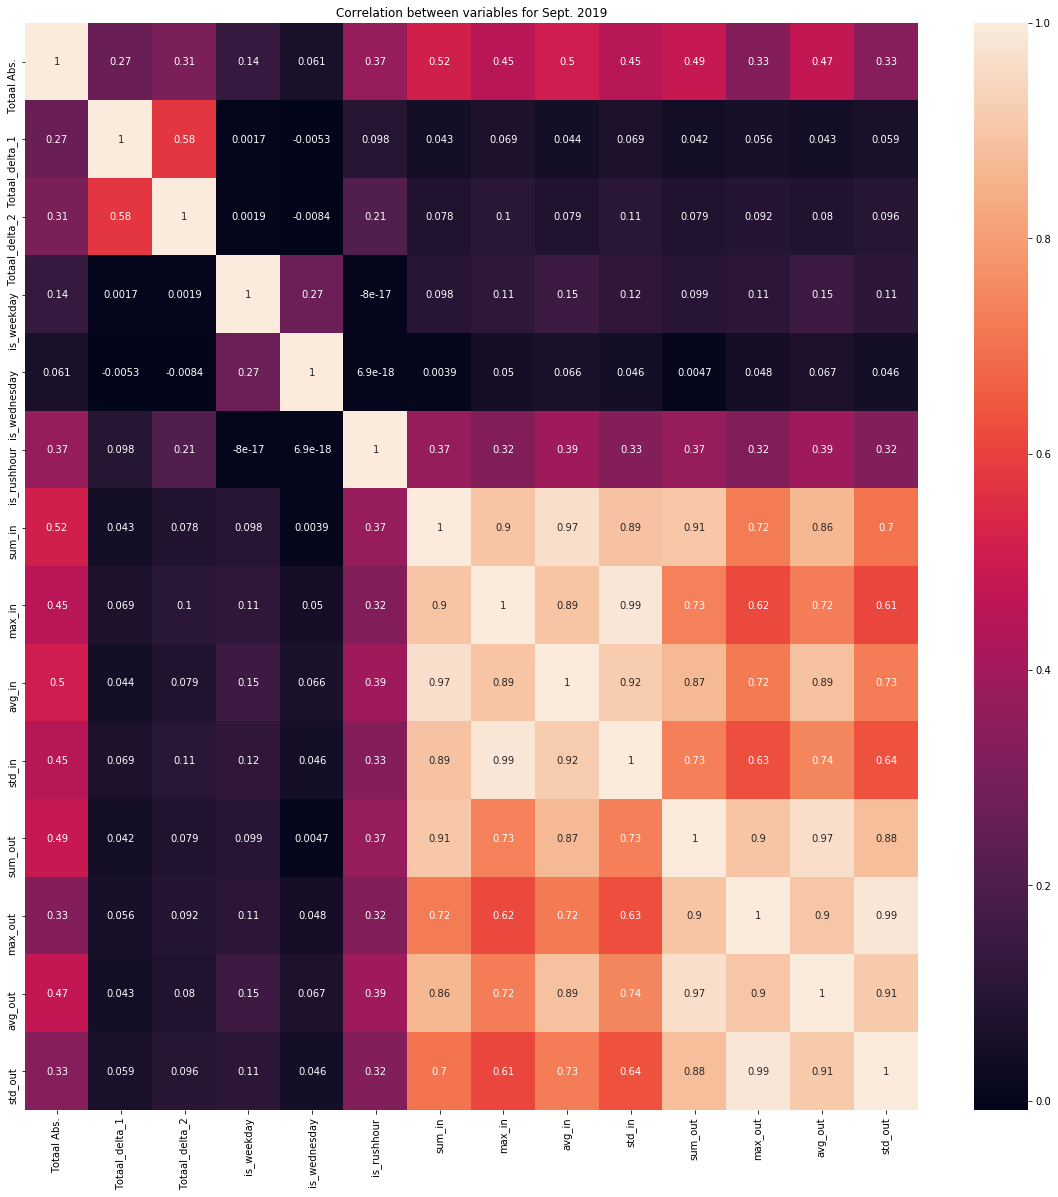

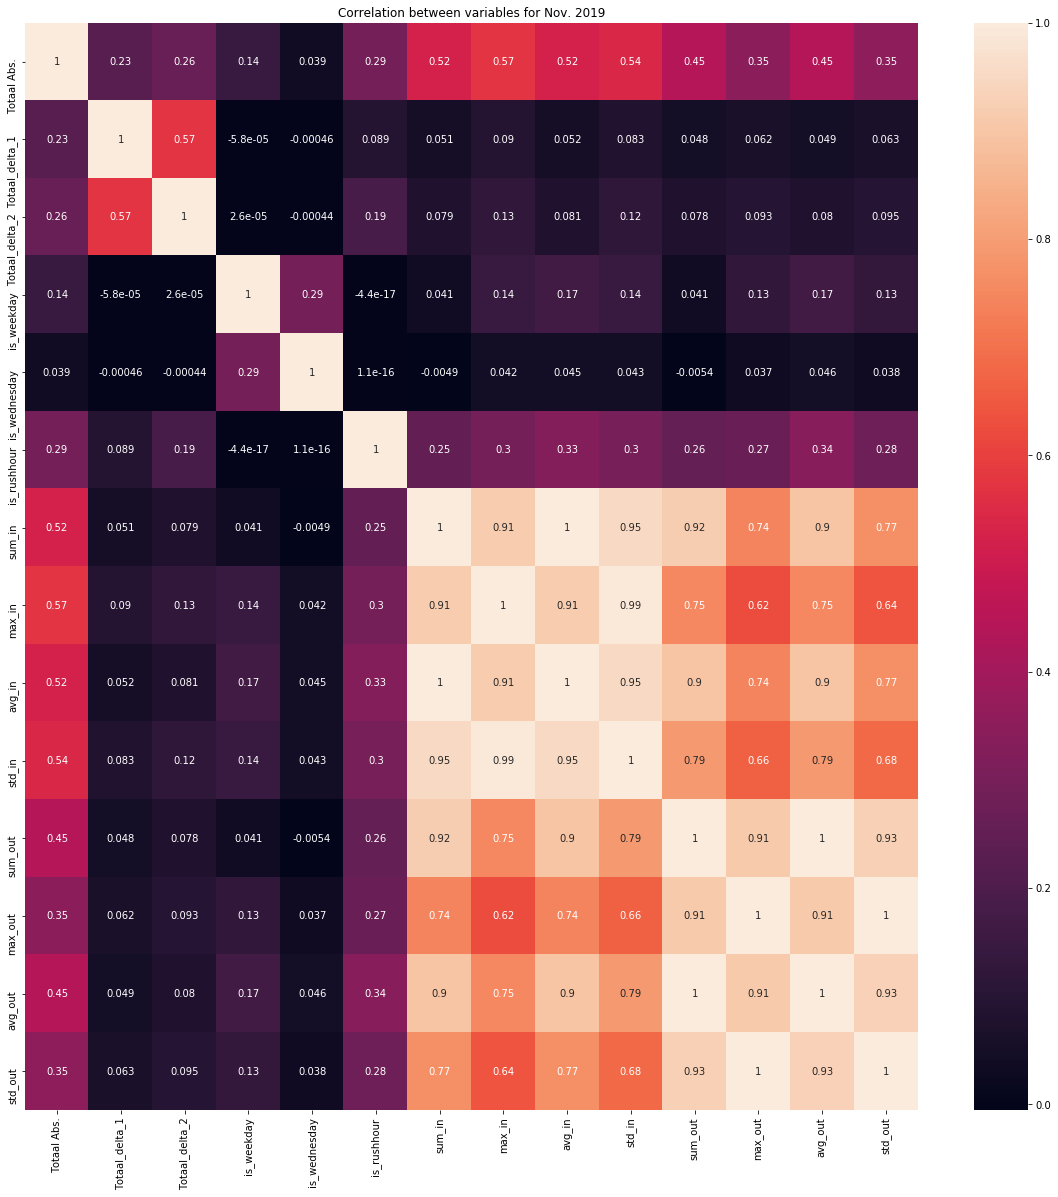

In [11]:
# Enrich the features for each sample by compute the weighted sum, max, min, avg, std of the traffic counts
# for the neighbouring detectors. 

df_enriched_sept = get_enriched_data_for_one_month(df_sept, df_channels, valid_channels_sept, weights_in_sept, weights_out_sept)
df_enriched_nov = get_enriched_data_for_one_month(df_nov, df_channels, valid_channels_nov, weights_in_nov, weights_out_nov)

df_enriched_sept = df_enriched_sept.astype('float32')
df_enriched_nov = df_enriched_nov.astype('float32')

# And then perform correlation analysis for selecting features
attr_corr_sept = df_enriched_sept.corr()
fig, ax = plt.subplots(figsize = (20,20))
g= sns.heatmap(attr_corr_sept,ax=ax, annot= True)
ax.set_title('Correlation between variables for Sept. 2019')

attr_corr_nov = df_enriched_nov.corr()
fig, ax = plt.subplots(figsize = (20,20))
g= sns.heatmap(attr_corr_nov,ax=ax, annot= True)
ax.set_title('Correlation between variables for Nov. 2019')

In [12]:

# Construct the build and test sets for different months
num_feaures, lst_df_build_sept, dict_df_test_sept = prepare_data_for_one_month(df_sept, df_channels,
                                                                               valid_channels_sept, weights_in_sept,
                                                                               weights_out_sept,
                                                                               test_split_time_sept_1,
                                                                               test_split_time_sept_2)

num_feaures, lst_df_build_nov, dict_df_test_nov = prepare_data_for_one_month(df_nov, df_channels,
                                                                             valid_channels_nov, weights_in_nov,
                                                                             weights_out_nov, test_split_time_nov_1,
                                                                             test_split_time_nov_2)
print(dict_df_test_sept['R3969_ch_1'][1].shape)
print(dict_df_test_nov['R3969_ch_1'][1].shape)

i = 0
for df_build_for_detector in lst_df_build_sept:
    if i == 0:
        df_build = df_build_for_detector
    else:
        df_build = df_build.append(df_build_for_detector, ignore_index=True)
    i += 1

for df_build_for_detector in lst_df_build_nov:
    df_build = df_build.append(df_build_for_detector, ignore_index=True)

print(df_build.shape)

# Convert dataframe of build set to a Numpy array
df_build_f32 = df_build.astype('float32')
# arr_build = df_build_f32.to_numpy()

scaler = StandardScaler()
arr_build = scaler.fit_transform(df_build_f32)

# Then, shuffle the build set and split it into training and validation sets
np.random.shuffle(arr_build)
np.random.shuffle(arr_build)

# idx_split = int(arr_build.shape[0] * 0.85)
# arr_train = arr_build[: idx_split, :]
# arr_valid = arr_build[idx_split:, :]

# split into input and outputs
train_X, train_y = arr_build[:, :-1], arr_build[:, -1]
# valid_X, valid_y = arr_valid[:, :-1], arr_valid[:, -1]

# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], num_timesteps, num_feaures))
# valid_X = valid_X.reshape((valid_X.shape[0], num_timesteps, num_feaures))

print(train_X.shape, train_y.shape)

# Convert the Numpy arrays to tensors
# train_X_torch = torch.tensor(train_X, dtype=torch.float32).to(device)
# train_y_torch = torch.tensor(train_y, dtype=torch.float32).to(device)

# valid_X_torch = torch.tensor(valid_X, dtype=torch.float32).to(device)
# valid_y_torch = torch.tensor(valid_y, dtype=torch.float32).to(device)

(135, 113)
(183, 113)
(34560, 113)
(34560, 112) (34560,)


In [13]:
# Build PureTSM model

print('\nModeling for the PureTSM ...')
    
    
model = xgb.XGBRegressor()


# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6],
#     'max_depth': [5, 6, 8, 10, 12],
#     # 'reg_alpha': [1.1, 1.2, 1.3],
#     # 'reg_lambda': [1.1, 1.2, 1.3],
#     # 'subsample': [0.7, 0.8, 0.9]
# }


param_grid = {
    'n_estimators': [200],
    'colsample_bytree': [0.4],
    'max_depth': [8],
    'reg_alpha': [1.3],
    'reg_lambda': [1.3],
    # 'subsample': [0.7, 0.8, 0.9]
}

model = algorithm_pipeline(train_X, train_y, model, param_grid, cv=10)    
    
# Root Mean Squared Error
print(model.best_score_)
print(model.best_params_)    



Modeling for the PureTSM ...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   56.7s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


[17:49:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8293336423132154
{'colsample_bytree': 0.4, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 1.3, 'reg_lambda': 1.3}


In [14]:
# Save model and scaler after training
model_file = "../models/xgbRegressor_hasselt.bin"
scaler_file = "../models/scaler_hasselt.pkl"

pickle.dump(model, open(model_file, "wb"))
pickle.dump(scaler, open(scaler_file, "wb"))
print(" -> saved {} and {}".format(model_file, scaler_file))

 -> saved ../models/xgbRegressor_hasselt.bin and ../models/scaler_hasselt.pkl


In [15]:
# load model and scaler from files
loaded_model = pickle.load(open(model_file, "rb"))
loaded_scaler = pickle.load(open(scaler_file, "rb"))

[17:50:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Test RMSE: 3.685
Test R^2: 0.775


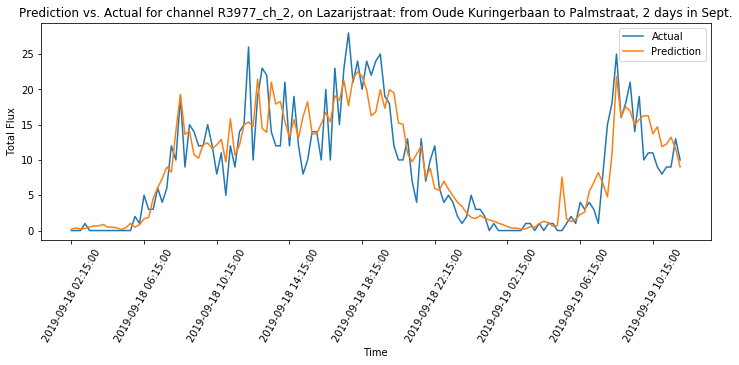

Test RMSE: 5.320
Test R^2: 0.856


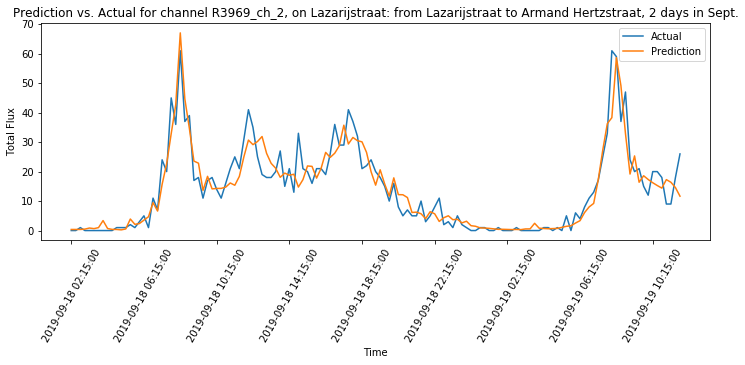

Test RMSE: 6.524
Test R^2: 0.798


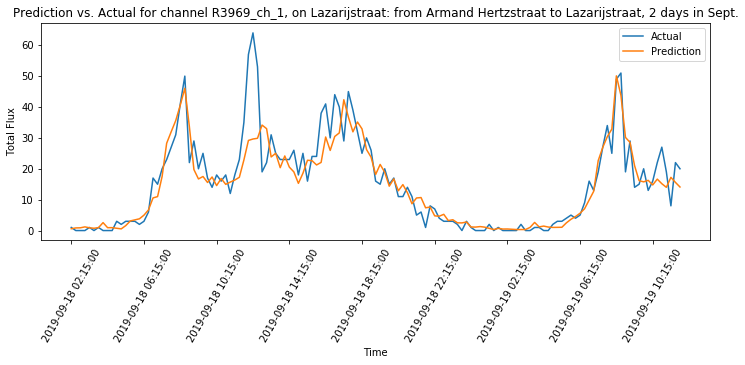

Test RMSE: 4.136
Test R^2: 0.760


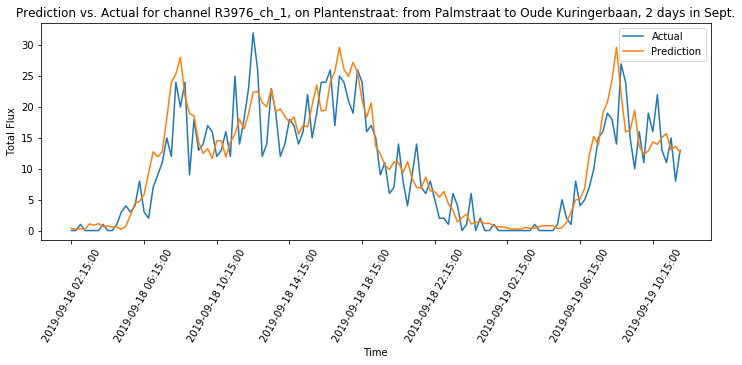

Test RMSE: 4.801
Test R^2: 0.836


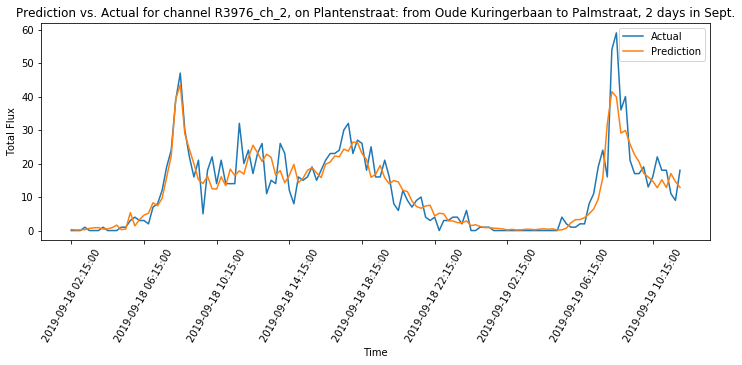

Test RMSE: 5.574
Test R^2: 0.834


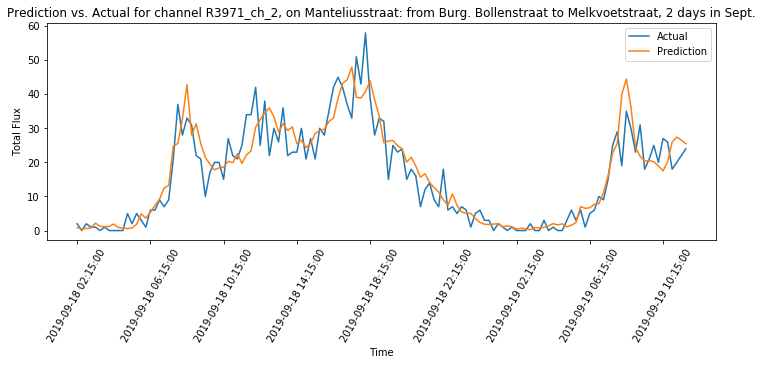

Test RMSE: 5.008
Test R^2: 0.867


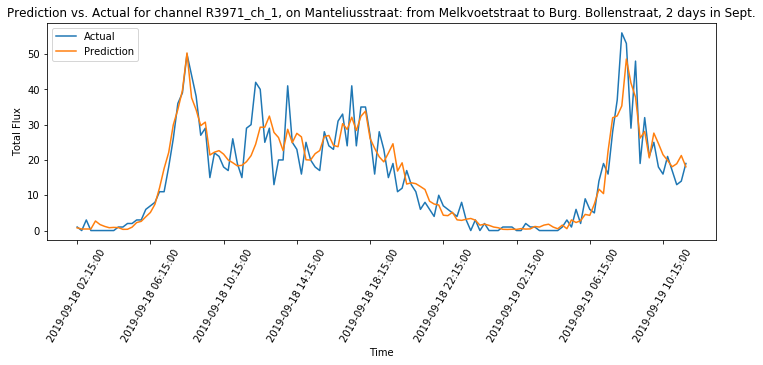

Test RMSE: 4.473
Test R^2: 0.798


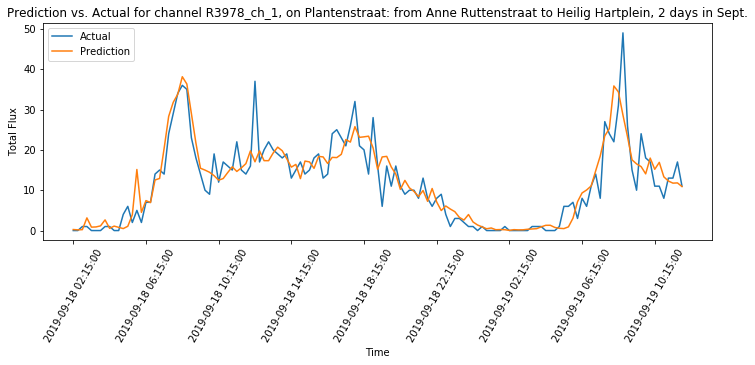

Test RMSE: 2.963
Test R^2: 0.750


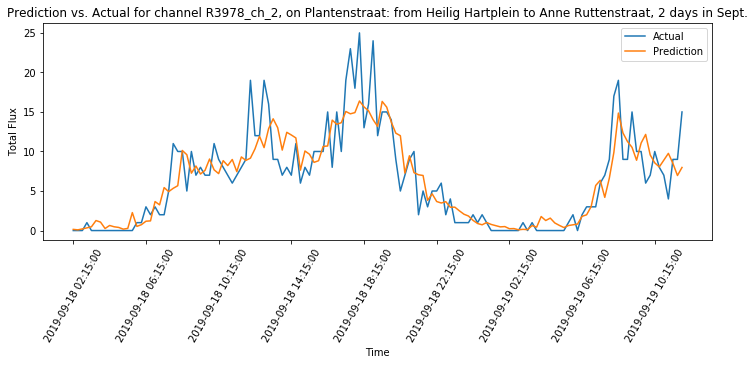

Test RMSE: 4.548
Test R^2: 0.824


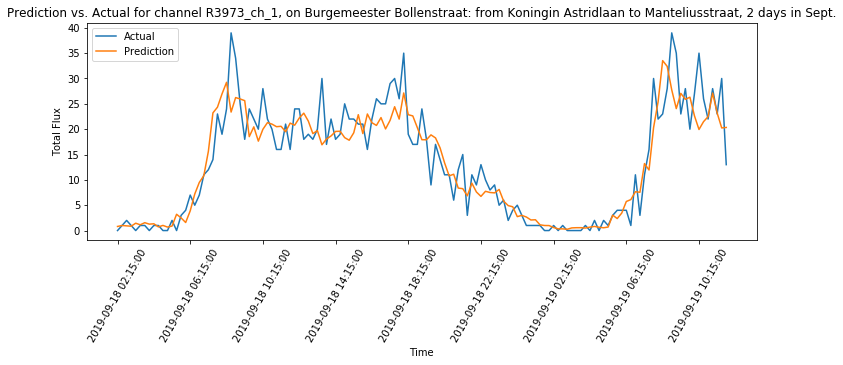

Test RMSE: 6.187
Test R^2: 0.837


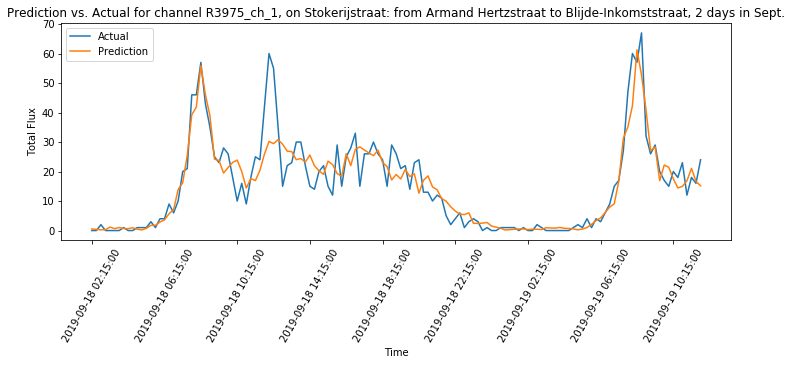

Test RMSE: 2.064
Test R^2: 0.568


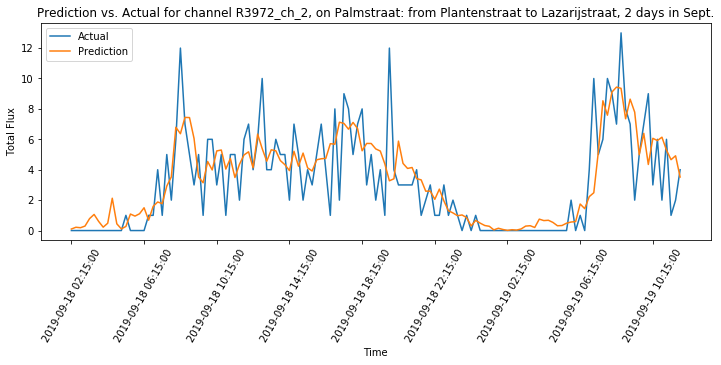

Test RMSE: 4.851
Test R^2: 0.842


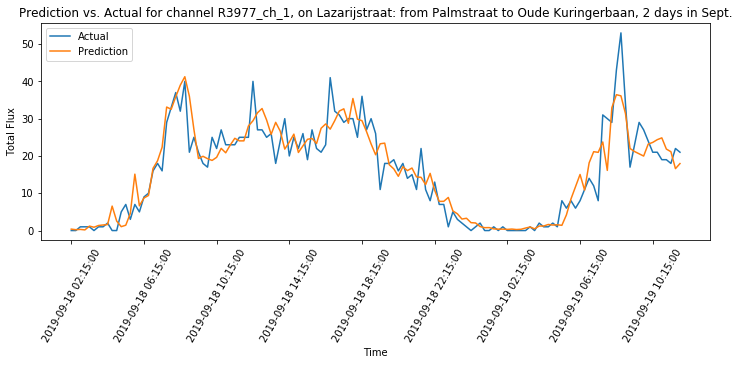

Test RMSE: 2.807
Test R^2: 0.663


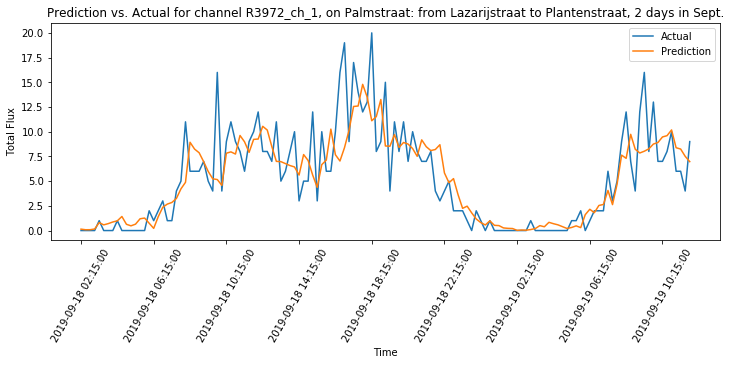

In [16]:
for key in dict_df_test_sept:
    df_channel = df_channels[df_channels['Channel'] == key]
    street = df_channel['Street'].iloc[0]
    start = df_channel['Start'].iloc[0]
    end = df_channel['End'].iloc[0]
  
    (test_x_arr, df_test) = dict_df_test_sept[key]
    df_test_f32 = df_test.astype('float32')
    data_arr_test = loaded_scaler.transform(df_test_f32)
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    # test_X = test_X.reshape((test_X.shape[0], num_timesteps, num_feaures))
    
    # ---------------- Make a prediction on the test set and evaluate the rusult for Sept. 
    test_y_pred = loaded_model.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = loaded_scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = loaded_scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for channel {key}, on {street}: from {start} to {end}, 2 days in Sept.', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=16),test_x_arr[::16], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Total Flux")
    plt.legend()
    # plt.grid(True)
    plt.show()    


Test RMSE: 3.685
Test R^2: 0.775


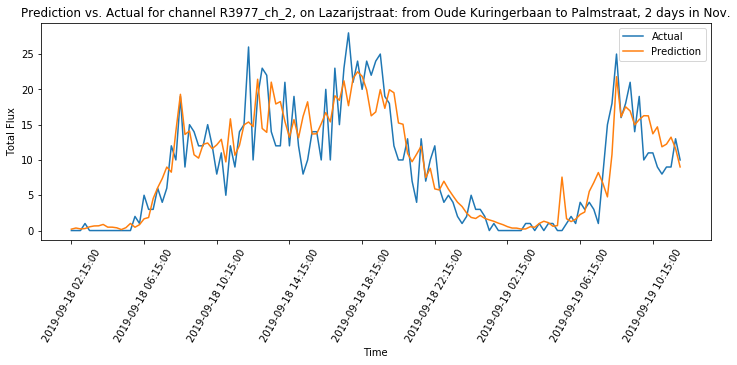

Test RMSE: 5.320
Test R^2: 0.856


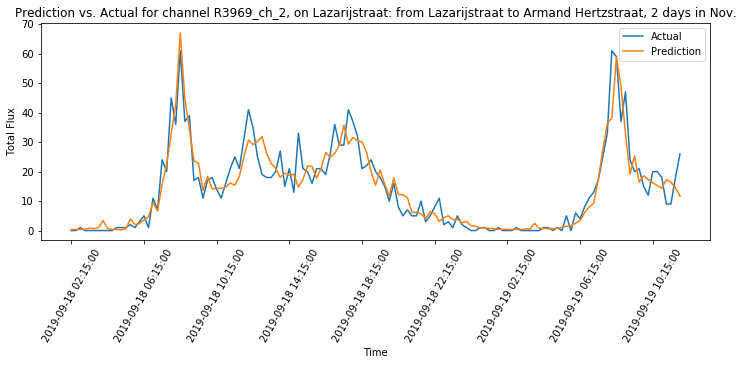

Test RMSE: 6.524
Test R^2: 0.798


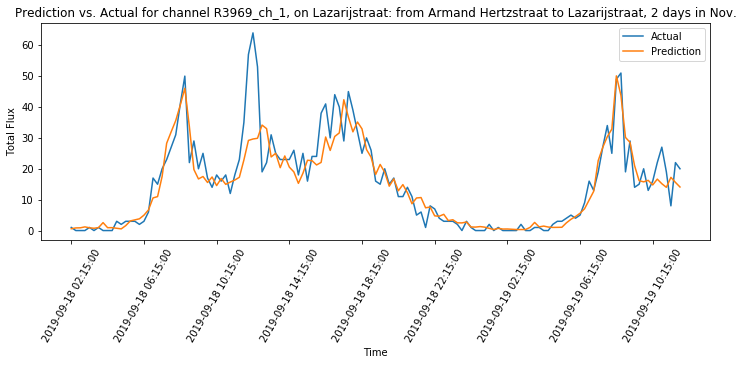

Test RMSE: 4.136
Test R^2: 0.760


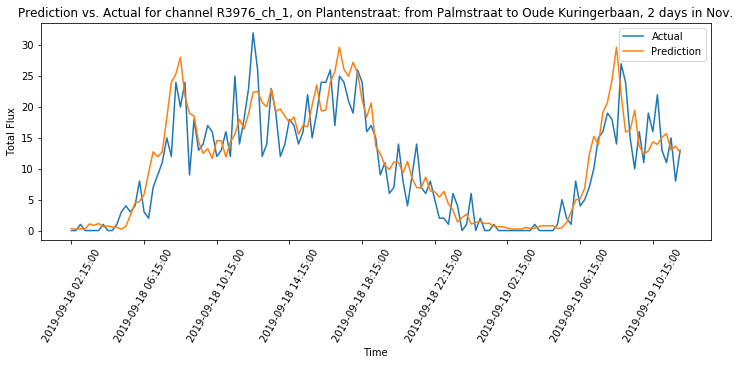

Test RMSE: 4.801
Test R^2: 0.836


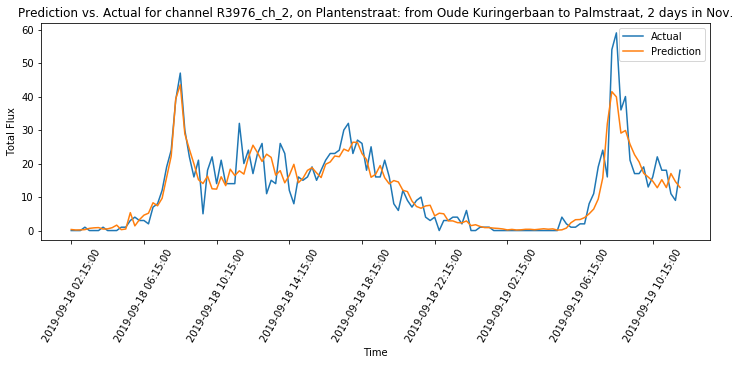

Test RMSE: 5.574
Test R^2: 0.834


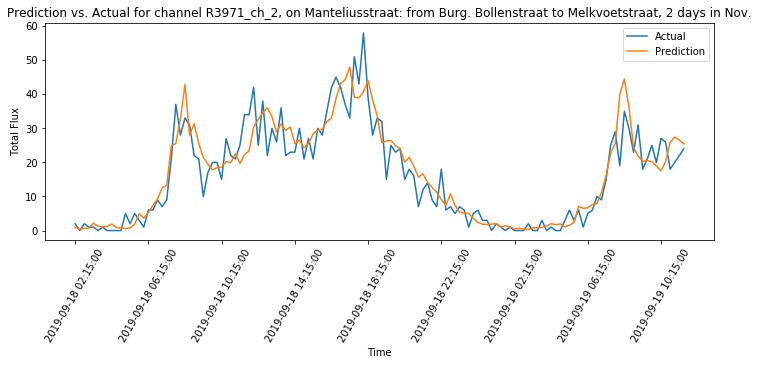

Test RMSE: 5.008
Test R^2: 0.867


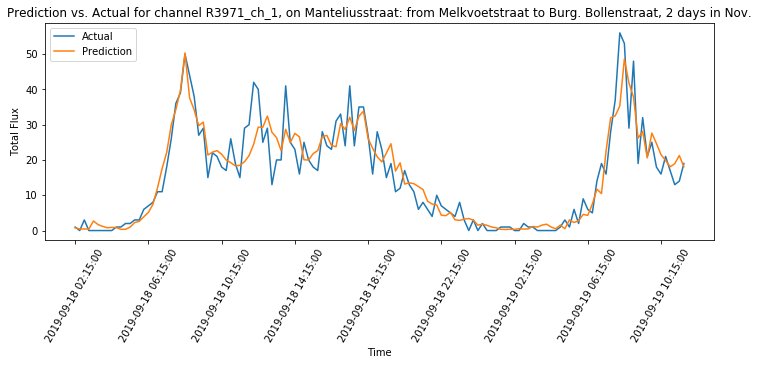

Test RMSE: 4.473
Test R^2: 0.798


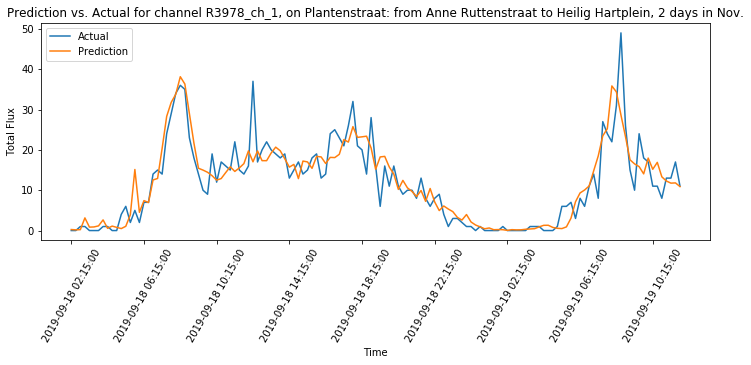

Test RMSE: 2.963
Test R^2: 0.750


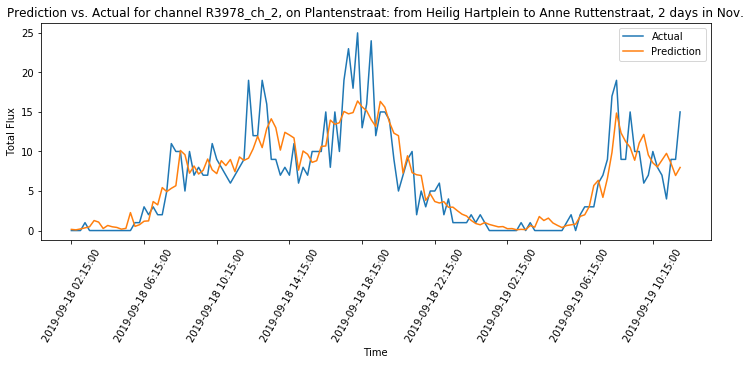

Test RMSE: 4.548
Test R^2: 0.824


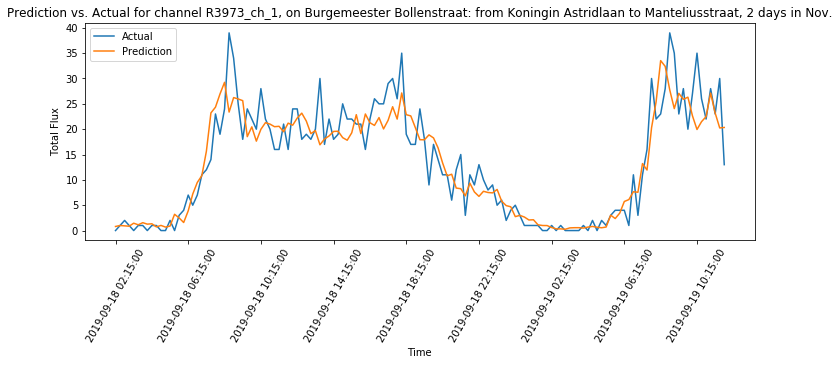

Test RMSE: 6.187
Test R^2: 0.837


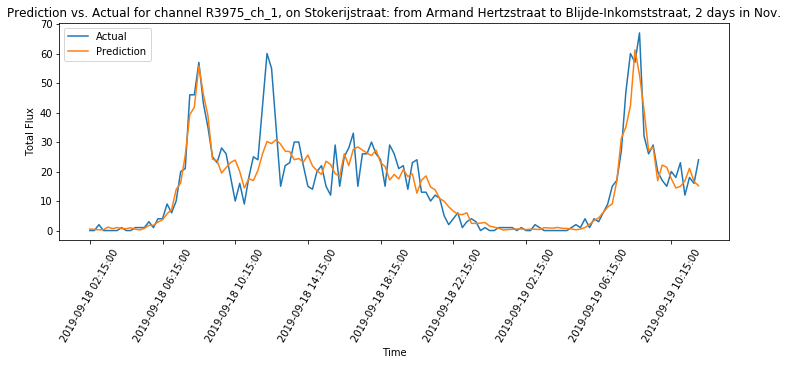

Test RMSE: 2.064
Test R^2: 0.568


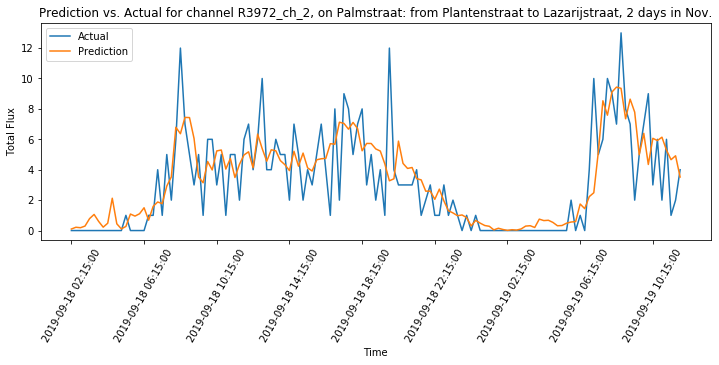

Test RMSE: 4.851
Test R^2: 0.842


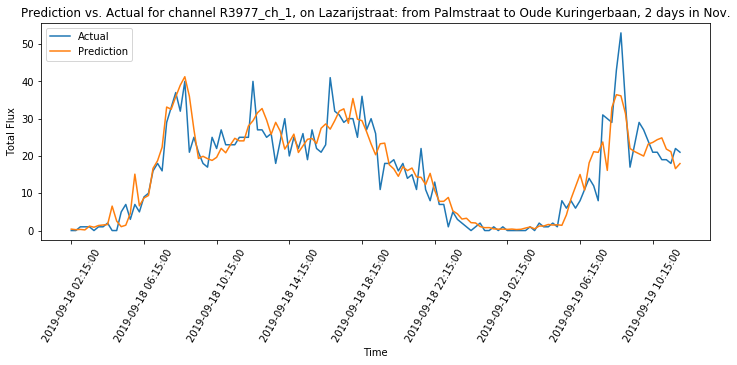

Test RMSE: 2.807
Test R^2: 0.663


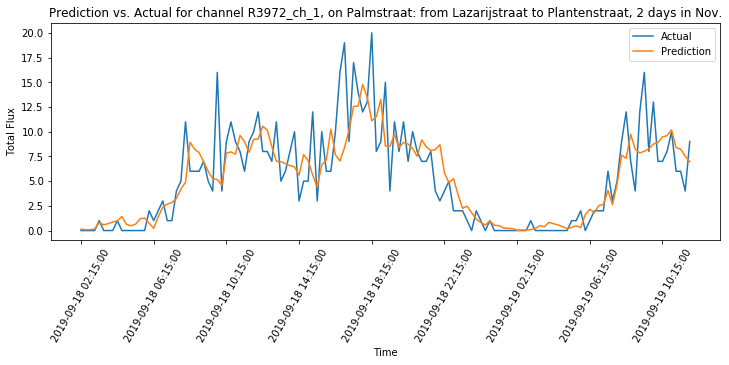

In [17]:
for key in dict_df_test_nov:
    df_channel = df_channels[df_channels['Channel'] == key]
    street = df_channel['Street'].iloc[0]
    start = df_channel['Start'].iloc[0]
    end = df_channel['End'].iloc[0]    
    
    (test_x_arr, df_test) = dict_df_test_sept[key]
    df_test_f32 = df_test.astype('float32')
    data_arr_test = loaded_scaler.transform(df_test_f32)
    test_X, test_y = data_arr_test[:, :-1], data_arr_test[:, -1]
    # test_X = test_X.reshape((test_X.shape[0], num_timesteps, num_feaures))
    
    # ---------------- Make a prediction on the test set and evaluate the rusult for Sept. 
    test_y_pred = loaded_model.predict(test_X)
    test_y_pred = test_y_pred.reshape((len(test_y_pred), 1))
    # test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, test_y_pred), axis=1)
    inv_yhat = loaded_scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_X, test_y), axis=1)
    inv_y = loaded_scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]

    # calculate RMSE and R^2
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test R^2: %.3f' % r2)

    # Plot the prediction vs. test set
    plt.figure(figsize=(12, 4))
    plt.title(f'Prediction vs. Actual for channel {key}, on {street}: from {start} to {end}, 2 days in Nov.', fontsize=12)
    plt.plot(inv_y, label="Actual")
    plt.plot(inv_yhat, label="Prediction")
    plt.xticks(np.arange(0, len(test_x_arr), step=16),test_x_arr[::16], rotation=60)
    plt.xlabel("Time")
    plt.ylabel("Total Flux")
    plt.legend()
    # plt.grid(True)
    plt.show()    


In [18]:
# Save training sets and test sets
bulid_sets_sept_file = "../data/hasselt_build_sets_sept.pkl"
test_sets_sept_file = "../data/hasselt_test_sets_sept.pkl"

pickle.dump(lst_df_build_sept, open(bulid_sets_sept_file, "wb"))
pickle.dump(dict_df_test_sept, open(test_sets_sept_file, "wb"))


bulid_sets_nov_file = "../data/hasselt_build_sets_nov.pkl"
test_sets_nov_file = "../data/hasselt_test_sets_nov.pkl"

pickle.dump(lst_df_build_nov, open(bulid_sets_nov_file, "wb"))
pickle.dump(dict_df_test_nov, open(test_sets_nov_file, "wb"))
